#### Importación de bibliotecas

In [1]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy import stats
from scipy.stats import pearsonr

## Carga de la base de datos

In [2]:
df = pd.read_csv("../Data/tourist_accommodation_clean.csv")
pd.set_option('display.max_columns', None)
df.head()

,apartment_id,name,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,city,insert_date,price_category
0,11964,A ROOM WITH A VIEW,45553,Centro,Desconocido,Private room,2,2.0,1.0,2,"TV,Internet,Wifi,Air conditioning,Elevator,Buz...",400.0,3,365,True,7,20,40,130,78,2010-02-01,2017-05-09,970.0,100.0,100.0,100.0,100.0,100.0,100.0,False,75.0,malaga,2018-07-31,Económico
1,21853,Bright and airy room,83531,C�rmenes,Latina,Private room,1,1.0,1.0,1,"TV,Internet,Wifi,Air conditioning,Kitchen,Free...",170.0,4,40,True,0,0,0,162,33,2014-10-10,NaN,920.0,90.0,90.0,100.0,100.0,80.0,90.0,False,52.0,madrid,2020-01-10,Económico
2,32347,Explore Cultural Sights from a Family-Friendly...,139939,San Vicente,Casco Antiguo,Entire home/apt,4,1.0,2.0,4,"TV,Internet,Wifi,Air conditioning,Wheelchair a...",990.0,2,120,True,26,31,31,270,148,2011-05-01,NaN,980.0,100.0,100.0,100.0,100.0,100.0,100.0,True,142.0,sevilla,2019-07-29,Alto
3,35379,Double 02 CasanovaRooms Barcelona,152232,l'Antiga Esquerra de l'Eixample,Eixample,Private room,2,2.0,1.0,2,"TV,Internet,Wifi,Kitchen,Breakfast,Elevator,Bu...",400.0,2,730,True,9,23,49,300,292,NaN,2020-04-01,940.0,100.0,90.0,100.0,100.0,100.0,90.0,True,306.0,barcelona,2020-01-10,Económico
4,35801,Can Torras Farmhouse Studio Suite,153805,Quart,Desconocido,Private room,5,1.0,2.0,5,"Wifi,Pool,Free parking on premises,Breakfast,P...",900.0,1,180,True,0,19,49,312,36,2011-08-07,2018-08-08,970.0,100.0,100.0,100.0,100.0,100.0,100.0,False,39.0,girona,2019-02-19,Medio


In [3]:
registros_totales = len(df)
print(f'Total de registros de la DB: {registros_totales}')

Total de registros de la DB: 10000


##### Análisis estadísticos y outliers


 Distribución Variables Numéricas:

                               Media  Desviación estándar  Mínimo  Q1 (25%)  Mediana  Q3 (75%)   Máximo
accommodates                    4.27                 2.58     1.0       2.0      4.0       6.0     29.0
bathrooms                       1.59                 0.99     0.0       1.0      1.0       2.0     13.0
bedrooms                        1.93                 1.37     0.0       1.0      2.0       3.0     50.0
beds                            4.27                 2.58     1.0       2.0      4.0       6.0     29.0
price                        1017.33               963.37    60.0     450.0    750.0    1200.0  28571.0
minimum_nights                  4.95                17.73     1.0       1.0      2.0       4.0   1125.0
maximum_nights                759.77               498.37     1.0      62.0   1125.0    1125.0   1125.0
availability_30                13.01                11.84     0.0       0.0     11.0      26.0     30.0
availability_60            

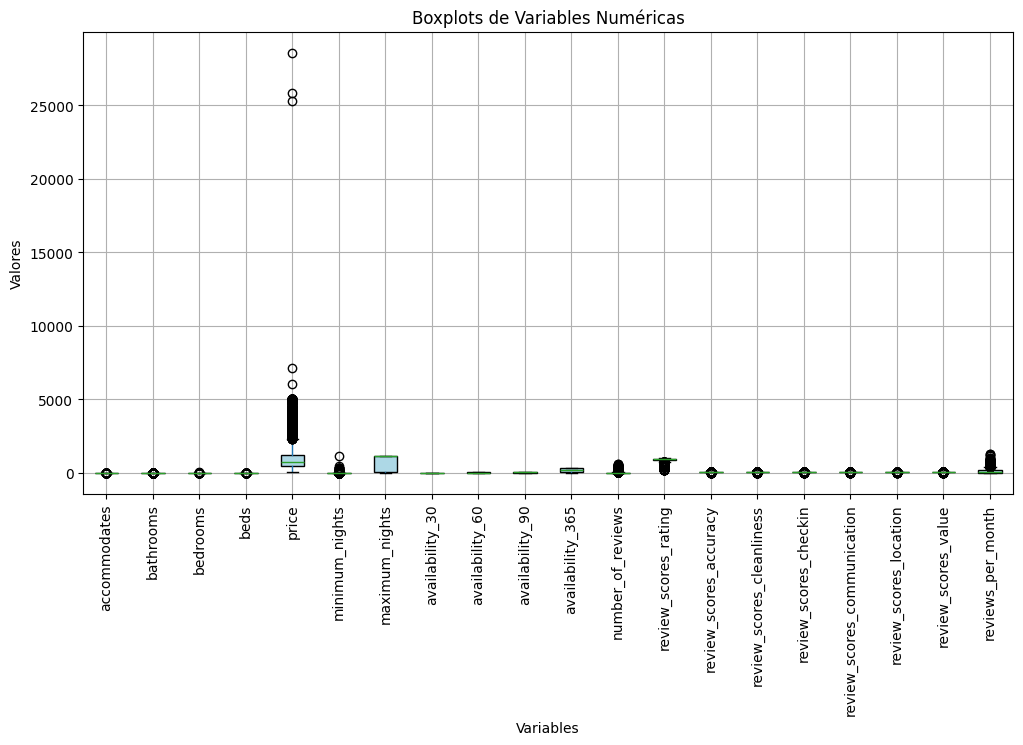

In [4]:
# Filtrar solo variables numéricas
df_numericas = df.select_dtypes(include=[np.number]).drop(columns=['apartment_id', 'host_id'],errors = 'ignore')

# Calcular estadísticas básicas
estadisticas = df_numericas.describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
estadisticas.columns = ['Media', 'Desviación estándar', 'Mínimo', 'Q1 (25%)', 'Mediana', 'Q3 (75%)', 'Máximo']

# Redondear a dos decimales
estadisticas = estadisticas.round(2)

# Mostrar estadísticas
print("\n Distribución Variables Numéricas:\n")
print(estadisticas.to_string())

# Crear boxplots de todas las variables numéricas
plt.figure(figsize=(12, 6))
df_numericas.boxplot(rot=90, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.title("Boxplots de Variables Numéricas")
plt.xlabel("Variables")
plt.ylabel("Valores")
plt.grid(True)
plt.show()

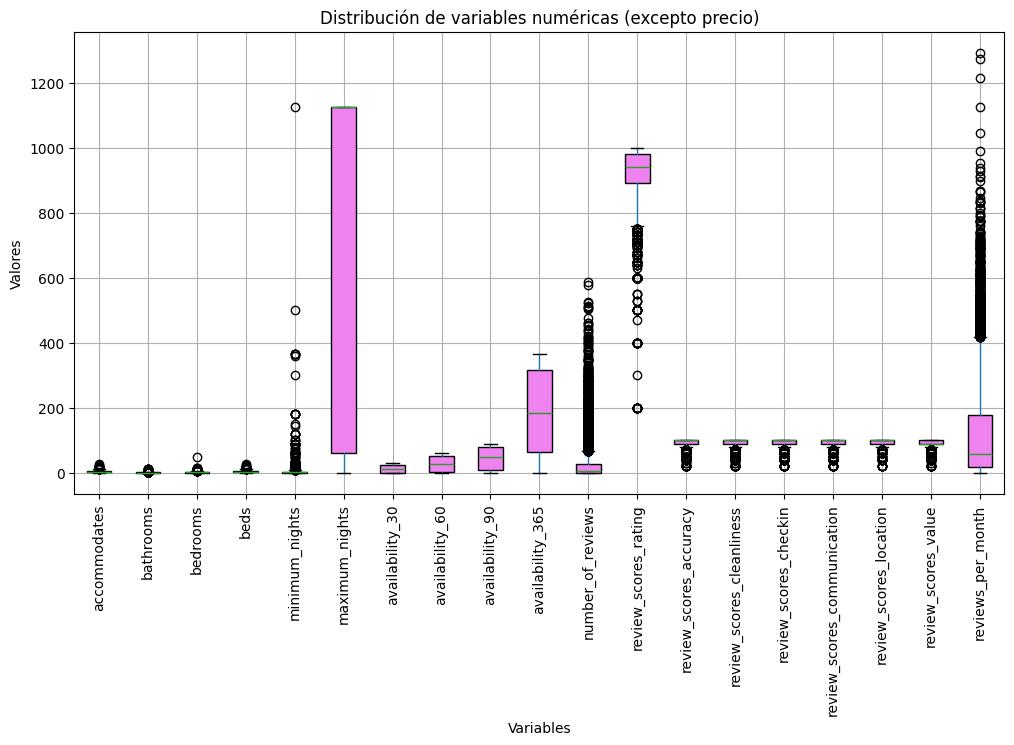

In [5]:
# nuevo gráfico para poder ver mejor las distribuciones

df_no_price = df_numericas.drop('price', axis=1)
plt.figure(figsize=(12, 6))
df_no_price.boxplot(rot=90, patch_artist=True, boxprops=dict(facecolor="violet"))
plt.title("Distribución de variables numéricas (excepto precio)")
plt.xlabel("Variables")
plt.ylabel("Valores")
plt.grid(True)
plt.show()

### Limpieza de duplicados

In [6]:
# se ordenan por fecha, se conserva el primer registro duplicado
df = (df.sort_values(by='insert_date')
    .drop_duplicates(subset='apartment_id', keep='first')
    .reset_index(drop=True)
)

df.duplicated(subset='apartment_id').sum()

np.int64(0)

### Verificación de nulos

In [7]:
df.isnull().sum()

apartment_id                      0
name                              0
host_id                           0
neighbourhood_name                0
neighbourhood_district            0
room_type                         0
accommodates                      0
bathrooms                         0
bedrooms                          0
beds                              0
amenities_list                    0
price                             0
minimum_nights                    0
maximum_nights                    0
has_availability                  0
availability_30                   0
availability_60                   0
availability_90                   0
availability_365                  0
number_of_reviews                 0
first_review_date              6647
last_review_date               6681
review_scores_rating           2625
review_scores_accuracy         2634
review_scores_cleanliness      2628
review_scores_checkin          2639
review_scores_communication    2630
review_scores_location      

## Total de registros del dataframe a trabajar

In [8]:
registros_totales = len(df)

duplicados = df['apartment_id'].duplicated().sum()

print(f'Total de registros del dataset: {registros_totales}')
print(f'Total de duplicados exactos: {df.duplicated().sum()}')
print(f"El número de apartment_id duplicados es: {duplicados}")

Total de registros del dataset: 9650
Total de duplicados exactos: 0
El número de apartment_id duplicados es: 0


## EDA CX

In [9]:
# valores únicos en cada columna
df.apply(pd.Series.nunique)

apartment_id                   9650
name                           9615
host_id                        7268
neighbourhood_name              521
neighbourhood_district           62
room_type                         4
accommodates                     21
bathrooms                        14
bedrooms                         15
beds                             21
amenities_list                 9488
price                           415
minimum_nights                   49
maximum_nights                  147
has_availability                  2
availability_30                  31
availability_60                  61
availability_90                  91
availability_365                366
number_of_reviews               317
first_review_date               875
last_review_date                599
review_scores_rating             46
review_scores_accuracy            9
review_scores_cleanliness         9
review_scores_checkin             8
review_scores_communication       8
review_scores_location      

### Filtrado de df sin reviews

In [10]:
df_no_reviews = df[df["number_of_reviews"] == 0]
df_with_reviews = df[df["number_of_reviews"] > 0]

registros_no_reviews = len(df_no_reviews)
registros_with_reviews = len(df_with_reviews)

no_review_percentage = ((df["number_of_reviews"] == 0).sum() / df["number_of_reviews"].count() * 100).round()

print(f'Registros totales: {registros_totales}\nTotal de registros sin reviews: {registros_no_reviews}\nTotal de registros con reviews: {registros_with_reviews}\nPorcentaje de alojamientos sin reviews: {no_review_percentage}%')

Registros totales: 9650
Total de registros sin reviews: 2544
Total de registros con reviews: 7106
Porcentaje de alojamientos sin reviews: 26.0%


In [11]:
df_with_reviews.isnull().sum()

apartment_id                      0
name                              0
host_id                           0
neighbourhood_name                0
neighbourhood_district            0
room_type                         0
accommodates                      0
bathrooms                         0
bedrooms                          0
beds                              0
amenities_list                    0
price                             0
minimum_nights                    0
maximum_nights                    0
has_availability                  0
availability_30                   0
availability_60                   0
availability_90                   0
availability_365                  0
number_of_reviews                 0
first_review_date              4117
last_review_date               4150
review_scores_rating            105
review_scores_accuracy          114
review_scores_cleanliness       108
review_scores_checkin           119
review_scores_communication     110
review_scores_location      

Dado que el filtrado por number_of_reviews deja más de 100 nulos para las variables que más nos interesarán en los análisis (accuracy, cleanlines, check-in, communication, location, value), se procede a filtrar por review_scores_rating, es decir, se conservarán para el análisis los registros que sí tengan calificación general (review_scores_rating).

### Filtrado de df sin rating

In [12]:
df_no_rating = df[pd.isna(df["review_scores_rating"])]
df_with_rating = df[df["review_scores_rating"].notna()]

registros_no_rating = len(df_no_rating)
registros_with_rating = len(df_with_rating)

no_rating_percentage = round((registros_no_rating / registros_totales) * 100, 2)
percent_total_records = round(((registros_totales - registros_no_rating) / registros_totales) * 100, 2)

print(f'Registros totales: {registros_totales}\nTotal de registros sin rating: {registros_no_rating}\nTotal de registros con rating: {registros_with_rating}\nPorcentaje de alojamientos sin rating: {no_rating_percentage}%\nPorcentaje de registros con que se trabaja con respecto al total: {percent_total_records}%')

Registros totales: 9650
Total de registros sin rating: 2625
Total de registros con rating: 7025
Porcentaje de alojamientos sin rating: 27.2%
Porcentaje de registros con que se trabaja con respecto al total: 72.8%


In [13]:
df_with_rating.isnull().sum()

apartment_id                      0
name                              0
host_id                           0
neighbourhood_name                0
neighbourhood_district            0
room_type                         0
accommodates                      0
bathrooms                         0
bedrooms                          0
beds                              0
amenities_list                    0
price                             0
minimum_nights                    0
maximum_nights                    0
has_availability                  0
availability_30                   0
availability_60                   0
availability_90                   0
availability_365                  0
number_of_reviews                 0
first_review_date              4067
last_review_date               4098
review_scores_rating              0
review_scores_accuracy            9
review_scores_cleanliness         3
review_scores_checkin            14
review_scores_communication       5
review_scores_location      

In [14]:
items = ['review_scores_accuracy', 'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_location', 'review_scores_value']
df_with_nulls = df_with_rating[df_with_rating[items].isna().any(axis=1)]
df_with_nulls.head()

,apartment_id,name,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,city,insert_date,price_category
278,7304217,Double room in penthouse with terrace,24516329,l'Antiga Esquerra de l'Eixample,Eixample,Private room,1,2.0,1.0,1,"TV,Cable TV,Internet,Wireless Internet,Air con...",390.0,14,1125,False,7,37,62,62,1,NaN,NaN,1000.0,NaN,NaN,NaN,100.0,100.0,100.0,True,5.0,barcelona,2017-04-08,Económico
335,16234816,"Beautiful Atico in Gracia, with a 70sqm Terrace",22118061,la Vila de Gr�cia,Gr�cia,Entire home/apt,3,1.0,1.0,3,"Internet,Wireless Internet,Air conditioning,Ki...",600.0,10,15,False,4,16,30,57,1,2017-02-01,2017-02-01,600.0,NaN,40.0,60.0,80.0,80.0,80.0,False,24.0,barcelona,2017-05-07,Accesible
394,18965530,Casa,92341350,el Guinard�,Horta-Guinard�,Private room,1,1.0,1.0,1,"TV,Cable TV,Wireless Internet,Wheelchair acces...",250.0,1,3,False,30,56,86,361,1,NaN,NaN,600.0,60.0,60.0,60.0,80.0,NaN,NaN,False,10.0,barcelona,2017-06-05,Económico
616,16209983,"Bright, stylish, central, near the Sagrada Fam...",5878688,la Dreta de l'Eixample,Eixample,Entire home/apt,4,2.0,2.0,4,"TV,Wireless Internet,Air conditioning,Kitchen,...",1350.0,2,29,True,5,29,53,317,2,2017-02-01,2017-12-02,1000.0,100.0,100.0,100.0,100.0,NaN,NaN,False,22.0,barcelona,2017-10-07,Alto
622,7113910,Cozy room with private balcony,37210379,l'Antiga Esquerra de l'Eixample,Eixample,Private room,2,1.0,1.0,2,"Wireless Internet,Kitchen,Buzzer/wireless inte...",400.0,1,1125,True,0,0,0,0,1,2015-10-07,2015-10-07,800.0,NaN,NaN,NaN,100.0,80.0,100.0,False,4.0,barcelona,2017-10-07,Económico


#### Imputación de valores nulos en los items

In [15]:
# se imputan los valores faltantes con la media y se verifica que los items no tengan nulos
df_with_rating[items] = df_with_rating[items].apply(lambda x: x.fillna(x.median()))

df_with_rating.isnull().sum()

C:\Users\Evelyn\AppData\Local\Temp\ipykernel_16044\3831790549.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_rating[items] = df_with_rating[items].apply(lambda x: x.fillna(x.median()))


apartment_id                      0
name                              0
host_id                           0
neighbourhood_name                0
neighbourhood_district            0
room_type                         0
accommodates                      0
bathrooms                         0
bedrooms                          0
beds                              0
amenities_list                    0
price                             0
minimum_nights                    0
maximum_nights                    0
has_availability                  0
availability_30                   0
availability_60                   0
availability_90                   0
availability_365                  0
number_of_reviews                 0
first_review_date              4067
last_review_date               4098
review_scores_rating              0
review_scores_accuracy            0
review_scores_cleanliness         0
review_scores_checkin             0
review_scores_communication       0
review_scores_location      

### Rating

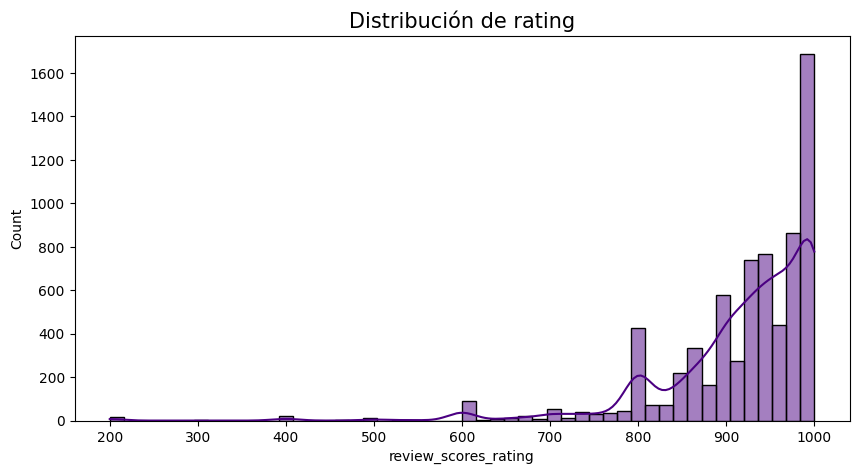

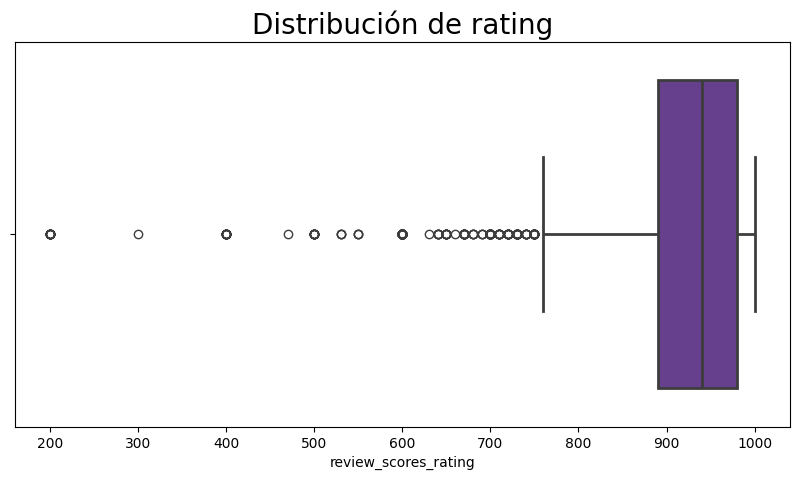

In [16]:
plt.figure(figsize=(10, 5))
sns.histplot(df_with_rating['review_scores_rating'], bins=50, kde=True, color='indigo')
plt.title('Distribución de rating', fontsize=15)


fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_with_rating, x='review_scores_rating', color='rebeccapurple', linewidth=2)
plt.title('Distribución de rating', fontsize=20)

plt.show();

### Accuracy

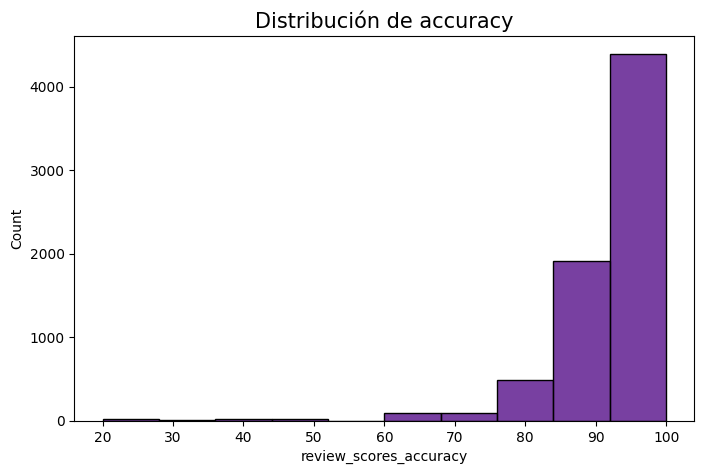

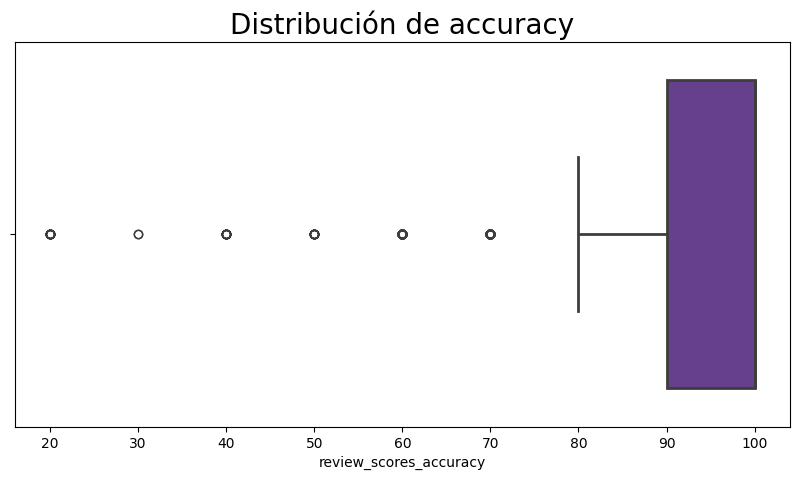

In [17]:
plt.figure(figsize=(8, 5))
sns.histplot(df_with_rating['review_scores_accuracy'], bins=10, color='indigo')
plt.title('Distribución de accuracy', fontsize=15)

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_with_rating, x='review_scores_accuracy', color='rebeccapurple', linewidth=2)
plt.title('Distribución de accuracy', fontsize=20)

plt.show();

### Cleanliness

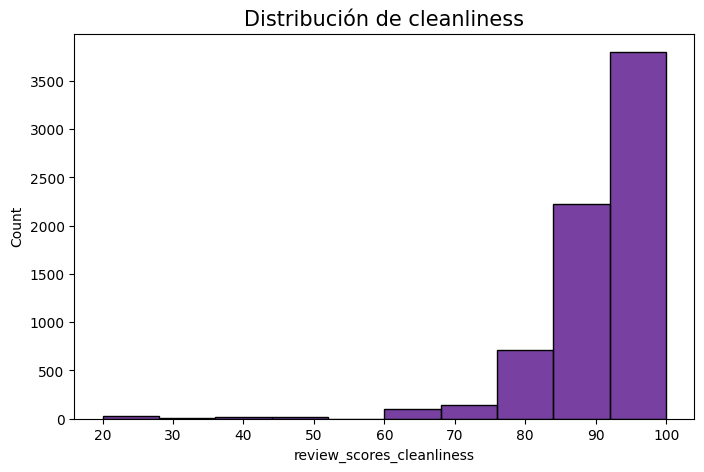

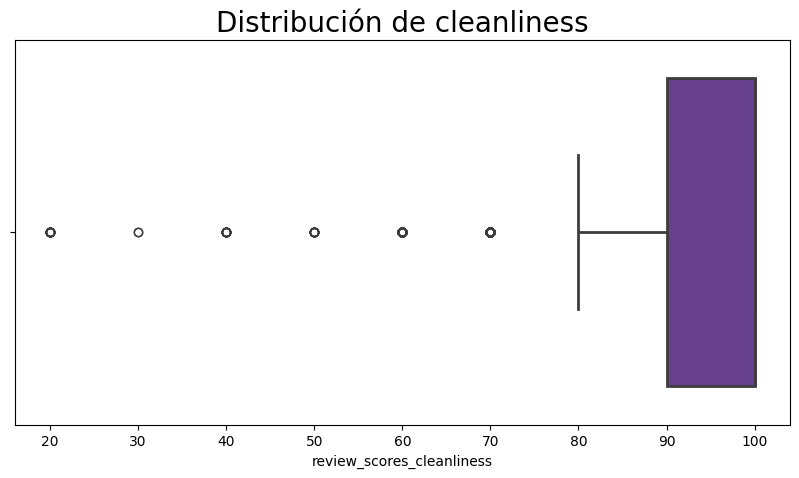

In [18]:
plt.figure(figsize=(8, 5))
sns.histplot(df_with_rating['review_scores_cleanliness'], bins=10, color='indigo')
plt.title('Distribución de cleanliness', fontsize=15)

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_with_rating, x='review_scores_cleanliness', color='rebeccapurple', linewidth=2)
plt.title('Distribución de cleanliness', fontsize=20)

plt.show();

### Checkin

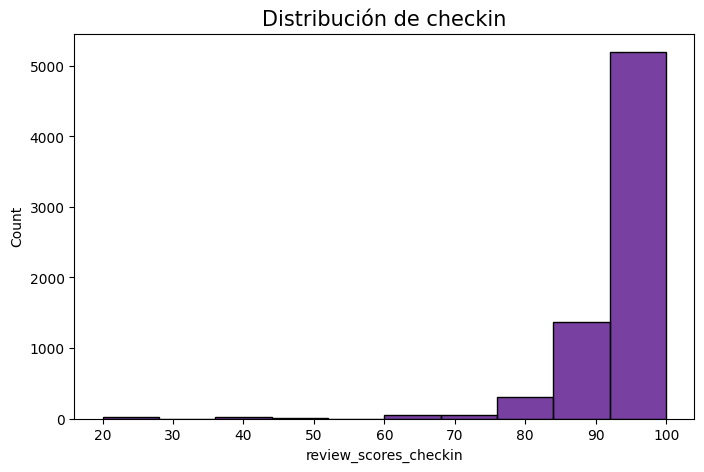

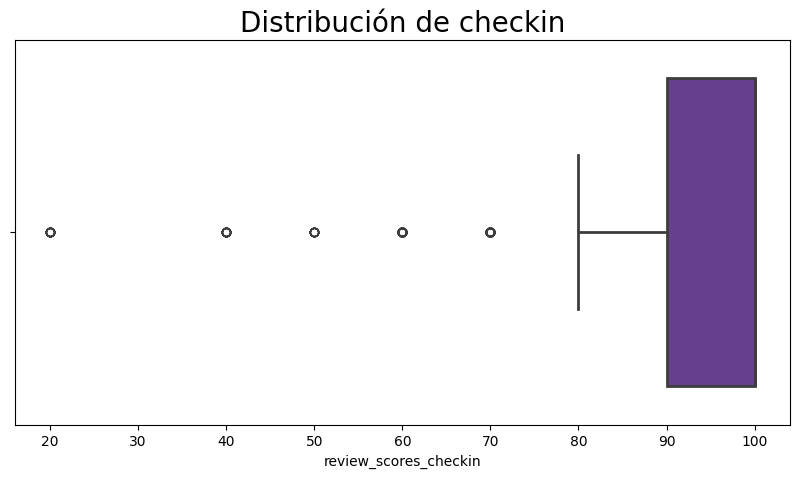

In [19]:
plt.figure(figsize=(8, 5))
sns.histplot(df_with_rating['review_scores_checkin'], bins=10, color='indigo')
plt.title('Distribución de checkin', fontsize=15)

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_with_rating, x='review_scores_checkin', color='rebeccapurple', linewidth=2)
plt.title('Distribución de checkin', fontsize=20)

plt.show();

### Communication

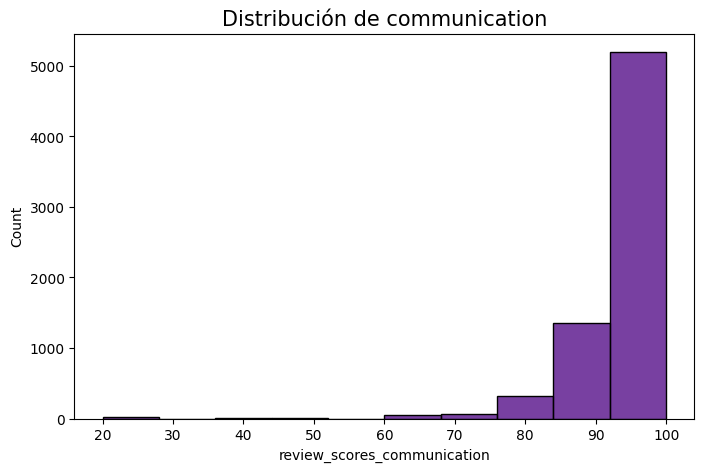

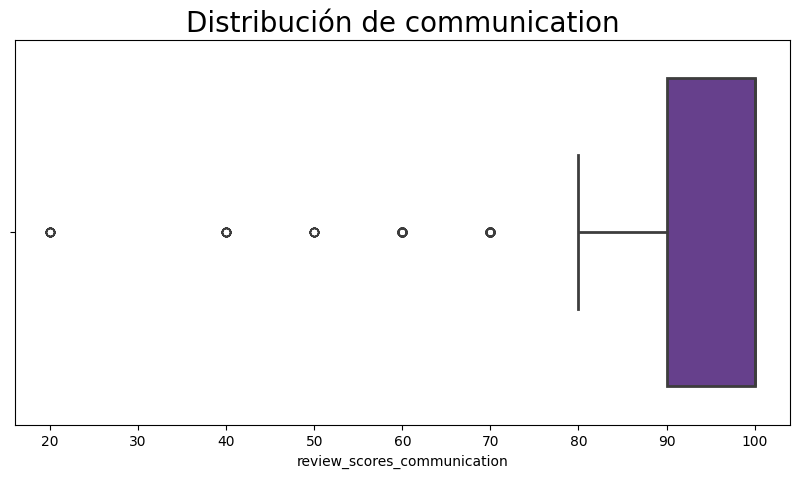

In [20]:
plt.figure(figsize=(8, 5))
sns.histplot(df_with_rating['review_scores_communication'], bins=10, color='indigo')
plt.title('Distribución de communication', fontsize=15)

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_with_rating, x='review_scores_communication', color='rebeccapurple', linewidth=2)
plt.title('Distribución de communication', fontsize=20)

plt.show();

### Location

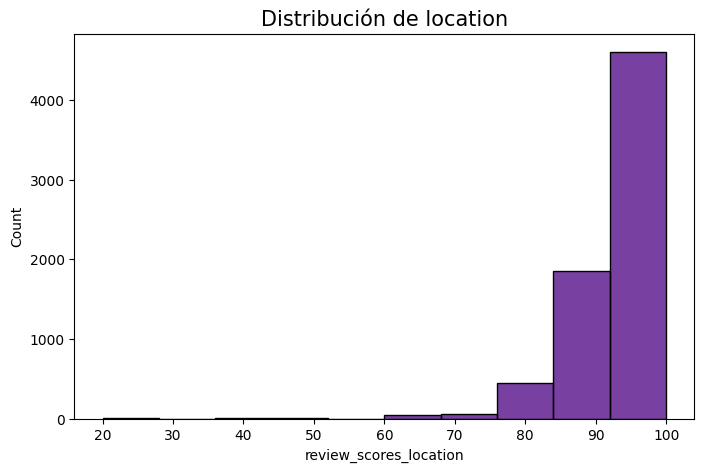

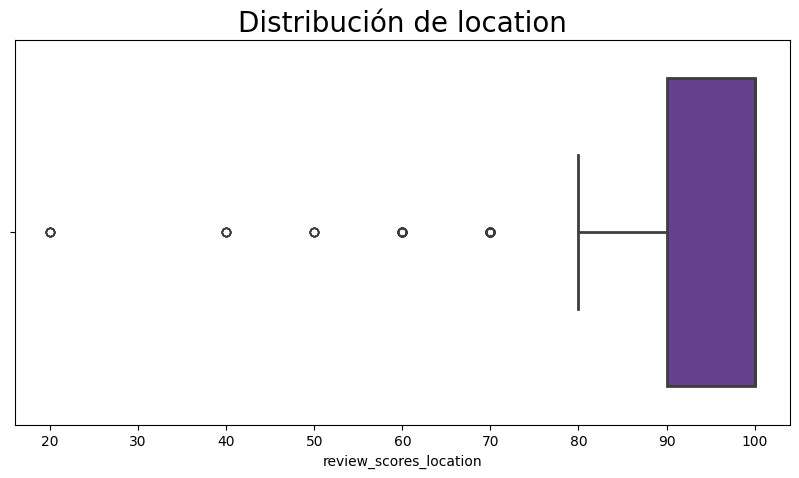

In [21]:
plt.figure(figsize=(8, 5))
sns.histplot(df_with_rating['review_scores_location'], bins=10, color='indigo')
plt.title('Distribución de location', fontsize=15)

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_with_rating, x='review_scores_location', color='rebeccapurple', linewidth=2)
plt.title('Distribución de location', fontsize=20)

plt.show();

### Value

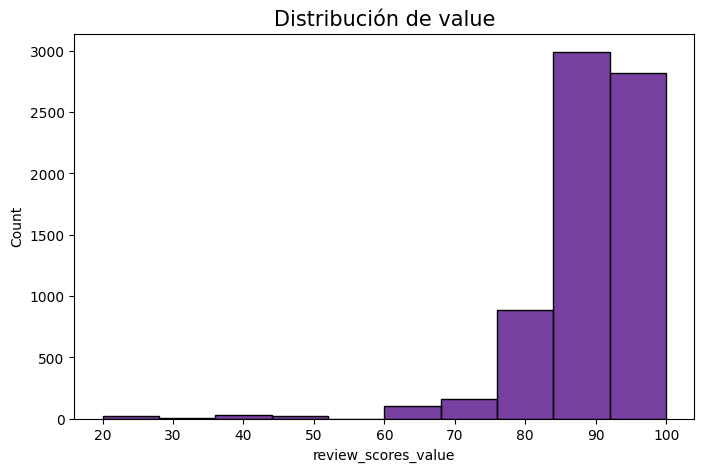

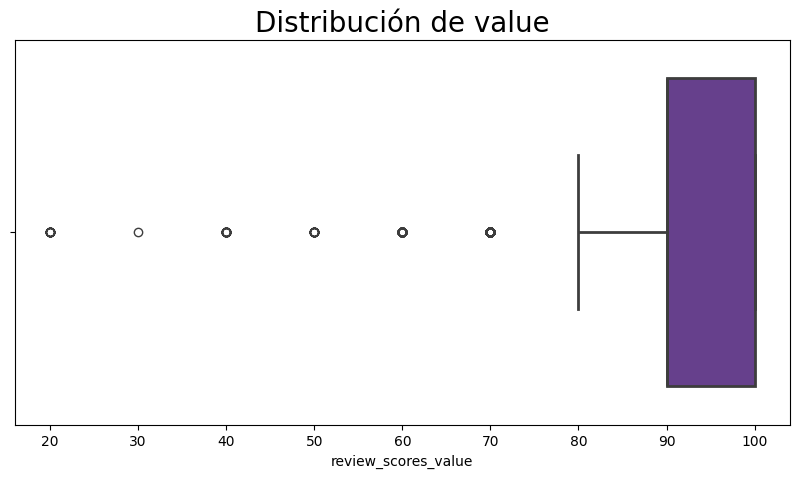

In [22]:
plt.figure(figsize=(8, 5))
sns.histplot(df_with_rating['review_scores_value'], bins=10, color='indigo')
plt.title('Distribución de value', fontsize=15)

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_with_rating, x='review_scores_value', color='rebeccapurple', linewidth=2)
plt.title('Distribución de value', fontsize=20)

plt.show();

### Relaciones entre variables

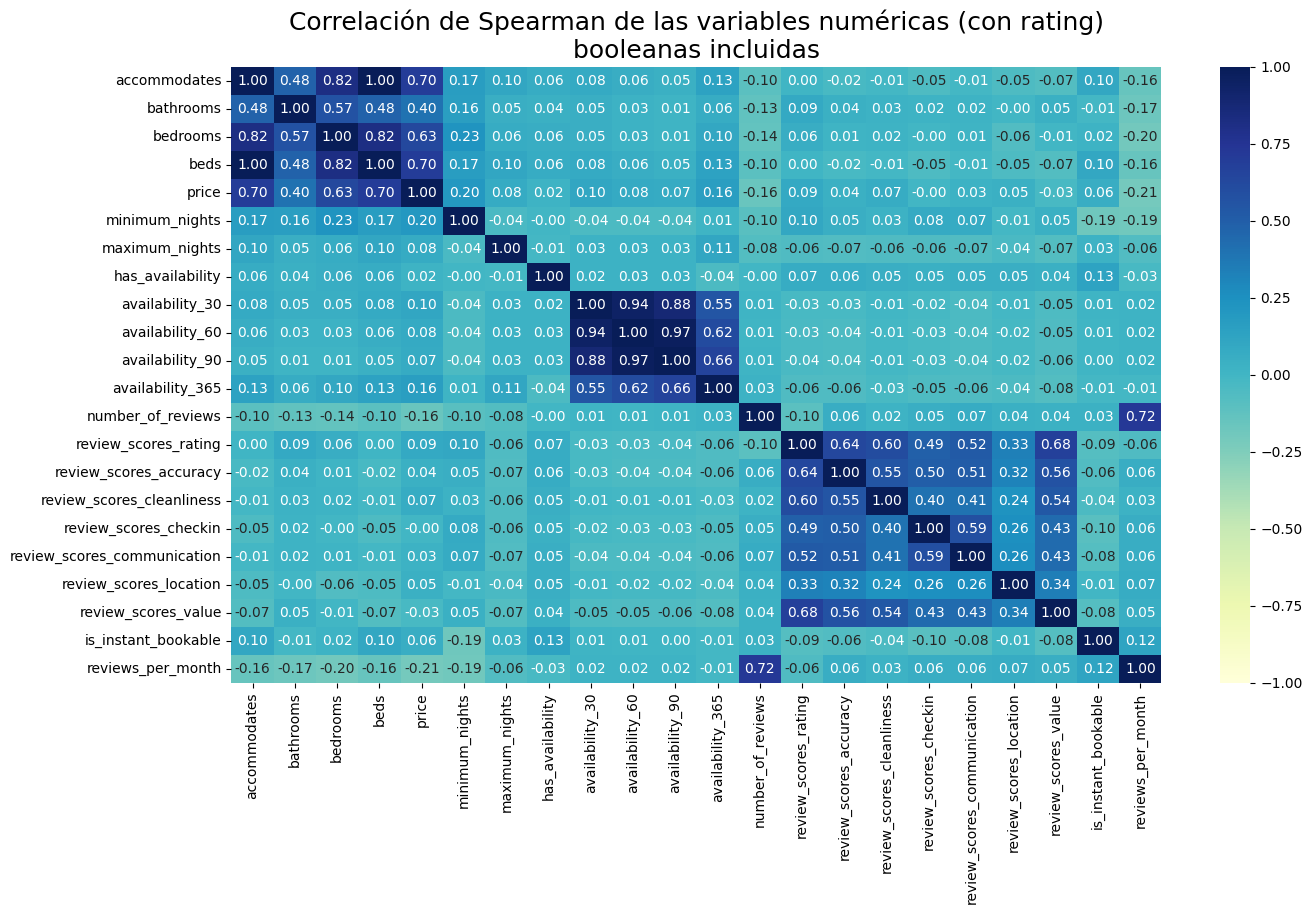

In [23]:
# correlación de Spearman con booleanas

non_num_variables = ['apartment_id', 'host_id']
df_numeric = df_with_rating.drop(columns=non_num_variables)

plt.figure(figsize=(15, 8))
sns.heatmap(df_numeric.corr(method='spearman', numeric_only=True), vmin= -1, vmax=1, annot=True, cmap='YlGnBu', fmt=".2f")

plt.title('Correlación de Spearman de las variables numéricas (con rating)\nbooleanas incluidas', fontsize=18)
plt.show();

En cuanto a las variables relativas a las reviews, hay correlaciones entre cada uno de los 6 items evaluados por los usuarios con respecto a la calificación general otorgada. La correlación más débil entre calificación general y un ítem concreto es la de la ubicación, seguida del check in. Esto puede deberse a que ubicación del alojamiento es una característica que el cliente ya conoce y acepta más fácilmente que los demás aspectos que pueden variar más y ser más objetivos y diferir de sus expectativas.

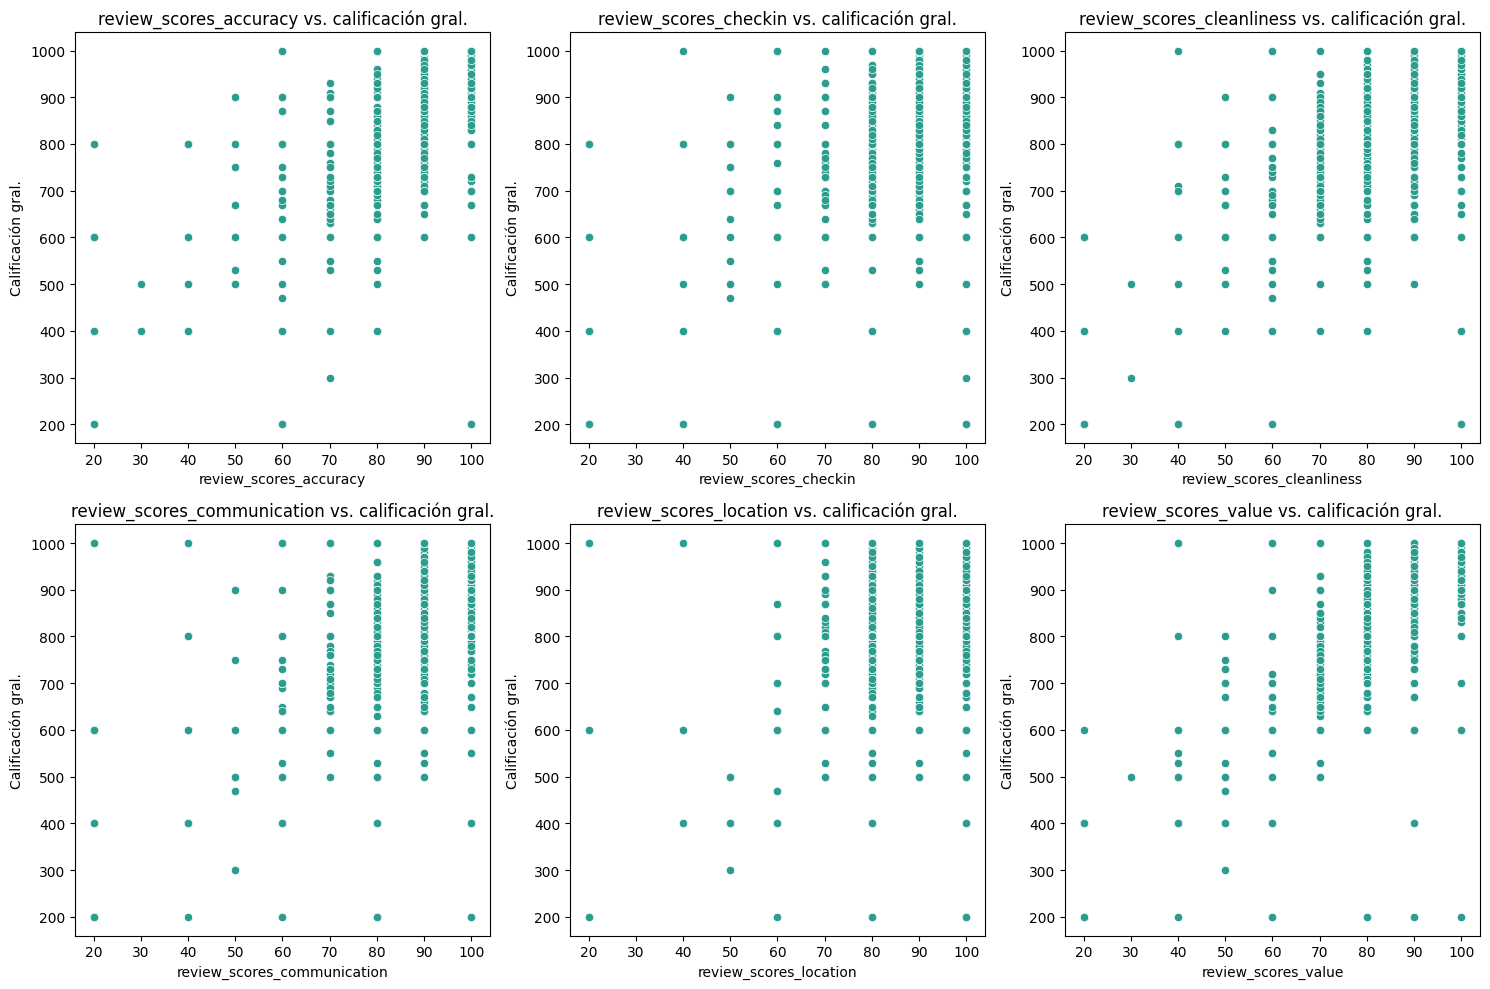

In [24]:
items = ['review_scores_accuracy', 'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_location', 'review_scores_value']

selected_columns = items + ['review_scores_rating']
df_selected = df_with_rating[selected_columns]

# scatterplots
plt.figure(figsize=(15, 10))

for i, category in enumerate(items, 1):
    plt.subplot(2, 3, i)  # 2 filas, 3 columnas
    sns.scatterplot(x=df_selected[category], y=df_selected['review_scores_rating'], color='#2A9D8F')
    
    plt.title(f"{category} vs. calificación gral.")
    plt.xlabel(category)
    plt.ylabel("Calificación gral.")

plt.tight_layout()
plt.show()

## KPIs de CX

### 3. Índice de satisfacción general
El índice de satisfacción general del cliente (CSAT) es el porcentaje de clientes satisfechos y se calcula sumando las puntuaciones otorgadas, diviendo entre el número total de respuestas y multiplicando por 100.

In [ ]:
csat_gral = df["review_scores_rating"].sum() / 10
print(f'Índice de satisfacción general: {csat_gral:.2f}%')

Índice de satisfacción general: 91.90%


In [26]:
# Este es el otro CSAT, solo las mejores puntuaciones

respuestas_top = df[(df['review_scores_rating'] >= 800) & (df['review_scores_rating'] <= 1000)]['review_scores_rating'].count()
respuestas_totales = df['review_scores_rating'].count()

csat = (respuestas_top / respuestas_totales) * 100

print(f"Índice de satisfacción CSAT: {csat:.2f}%")

Índice de satisfacción CSAT: 94.31%


### 4. Item con más satisfacción media

In [27]:
avg_accuracy = df["review_scores_accuracy"].mean().round(2)
avg_cleanliness = df["review_scores_cleanliness"].mean().round(2)
avg_chekin = df["review_scores_checkin"].mean().round(2)
avg_communication = df["review_scores_communication"].mean().round(2)
avg_location = df["review_scores_location"].mean().round(2)
avg_value = df["review_scores_value"].mean().round(2)

diccionario = {'avg_accuracy': avg_accuracy, 'avg_cleanliness': avg_cleanliness, 'avg_checkin': avg_chekin, 'avg_communication': avg_communication, 'avg_location': avg_location, 'avg_location': avg_value}

print(f'Item con más satisfacción media: {max(diccionario, key=diccionario.get)}')
print(f'Item con menor satisfacción media: {min(diccionario, key=diccionario.get)}')
print(f'Valores medios:\n    Accuracy: {avg_accuracy}\n    Cleanliness: {avg_cleanliness}\n    Checkin: {avg_chekin}\n    Communication: {avg_communication}\n    Location: {avg_location}\n    Value: {avg_value}')

Item con más satisfacción media: avg_checkin
Item con menor satisfacción media: avg_location
Valores medios:
    Accuracy: 94.49
    Cleanliness: 93.11
    Checkin: 96.22
    Communication: 96.2
    Location: 95.42
    Value: 91.37


# Desafío 3 
- ¿Existe una relación entre el precio del alojamiento y la satisfacción general de los clientes? 
- ¿Cómo varía esta relación en función de las diferentes ciudades donde se ubican los alojamientos?

Se comienza verificando el total de registros con que se trabaja y evaluando las variables relevantes para la pregunta de negocio: precio (price) y satisfacción general (review_scores_rating)

In [119]:
def conteo_dataset(df, df_with_rating, freq_column=None):
    """
    Cuenta los registros totales y filtrados (con rating) del dataset,
    calcula el porcentaje de registros que se conservan para el análisis
    y muestra tabla de frecuencia para la columna que se incluya.

    """
    registros_totales = len(df)
    registros_con_rating = len(df_with_rating)
    porcentaje_registros_usados = (registros_con_rating / registros_totales) * 100 if registros_totales > 0 else 0

    print("Resumen:")
    print(f"Registros totales: {registros_totales:}")
    print(f"Registros con rating: {registros_con_rating:}")
    print(f"Porcentaje de registros utilizados para el análisis: {porcentaje_registros_usados:.2f}%\n")

    if freq_column and freq_column in df_with_rating.columns:
        print(f"Tabla de frecuencia para '{freq_column}':")
        print(df_with_rating[freq_column].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

conteo_dataset(df, df_with_rating, 'price_category')

Resumen:
Registros totales: 9650
Registros con rating: 7025
Porcentaje de registros utilizados para el análisis: 72.80%

Tabla de frecuencia para 'price_category':
price_category
Económico    23.35%
Medio        21.57%
Accesible    20.01%
Alto         18.83%
Premium      15.59%
Exclusivo     0.65%
Name: proportion, dtype: object


## Precio - frecuencia

In [ ]:
# Definir los rangos de precios
bins = [0, 50, 100, 150, 200, 300, 500, 1000, df['price'].max()]
labels = ['0-50', '51-100', '101-150', '151-200', '201-300', '301-500', '501-1000', '1000+']

# Crear la columna de intervalos
df_with_rating['price_range'] = pd.cut(df_with_rating['price'], bins=bins, labels=labels, right=False)

# Tabla de frecuencia
tabla_frecuencia_precio = df_with_rating['price_range'].value_counts().sort_index()
tabla_frecuencia_precio

C:\Users\Evelyn\AppData\Local\Temp\ipykernel_16044\4018012315.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_rating['price_range'] = pd.cut(df_with_rating['price'], bins=bins, labels=labels, right=False)


price_range
0-50           0
51-100         8
101-150       58
151-200      160
201-300      553
301-500     1320
501-1000    2802
1000+       2124
Name: count, dtype: int64

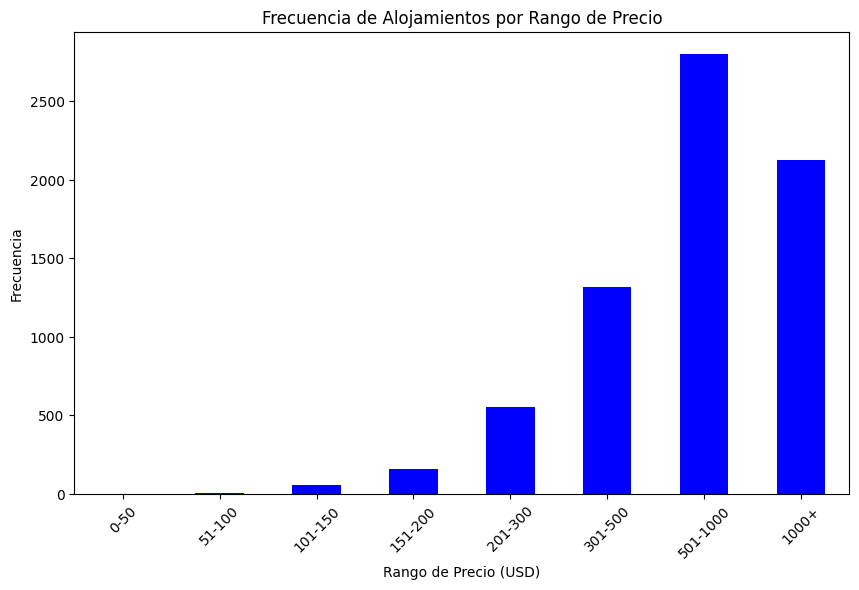

In [ ]:
# Graficar la tabla de frecuencia de precios
tabla_frecuencia_precio.plot(kind='bar', color='blue', figsize=(10, 6))
plt.xlabel('Rango de Precio (€)')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Alojamientos por Rango de Precio')
plt.xticks(rotation=45)
plt.show()


In [40]:
precio_maximo = df_with_rating['price'].max()
print(f'El precio más alto es: {precio_maximo} €')

El precio más alto es: 7143.0 €


### Tabla de frecuencia - precio, rating

In [127]:
# crear bins y etiquetas
rating_bins = range(0, 1100, 100)
rating_labels = range(1, 11)

# crear columna
df_with_rating['review_scores_binned'] = pd.cut(df_with_rating['review_scores_rating'], bins=rating_bins, labels=rating_labels, include_lowest=True)

# orden de las categorías de precio
orden_price_category=['Económico', 'Accesible', 'Medio', 'Alto', 'Premium', 'Exclusivo']
df_with_rating['price_category'] = pd.Categorical(df_with_rating['price_category'], categories=orden_price_category, ordered=True)

freq_table = pd.crosstab(df_with_rating['price_category'], df_with_rating['review_scores_binned'])
freq_table

C:\Users\Evelyn\AppData\Local\Temp\ipykernel_16044\1507899218.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_rating['review_scores_binned'] = pd.cut(df_with_rating['review_scores_rating'], bins=rating_bins, labels=rating_labels, include_lowest=True)
C:\Users\Evelyn\AppData\Local\Temp\ipykernel_16044\1507899218.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_rating['price_category'] = pd.Categorical(df_with_rating['price_category'], categories=orden_price_category, ordered=True)


review_scores_binned,2,3,4,5,6,7,8,9,10
price_category,,,,,,,,,
Económico,5,1,5,3,21,26,136,370,1073
Accesible,2,0,3,3,20,16,98,309,955
Medio,6,0,6,3,20,11,143,306,1020
Alto,2,0,2,1,18,19,115,250,916
Premium,2,0,3,2,16,17,95,189,771
Exclusivo,0,0,0,0,0,0,4,12,30


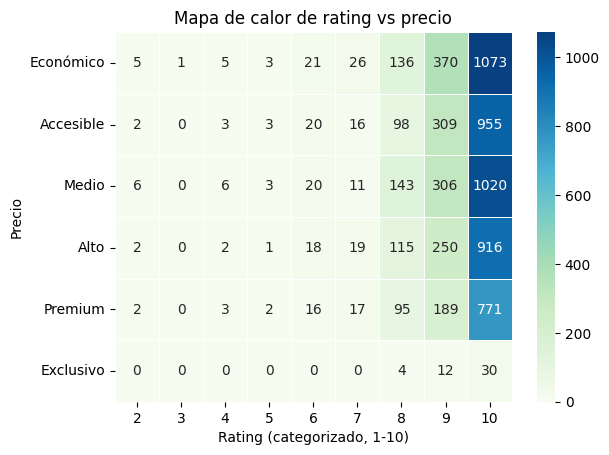

In [128]:
sns.heatmap(freq_table, annot=True, fmt='d', cmap='GnBu', linewidths=0.5)

plt.title("Mapa de calor de rating vs precio")
plt.xlabel("Rating (categorizado, 1-10)")
plt.ylabel("Precio")
plt.show()

## Precio - distribución

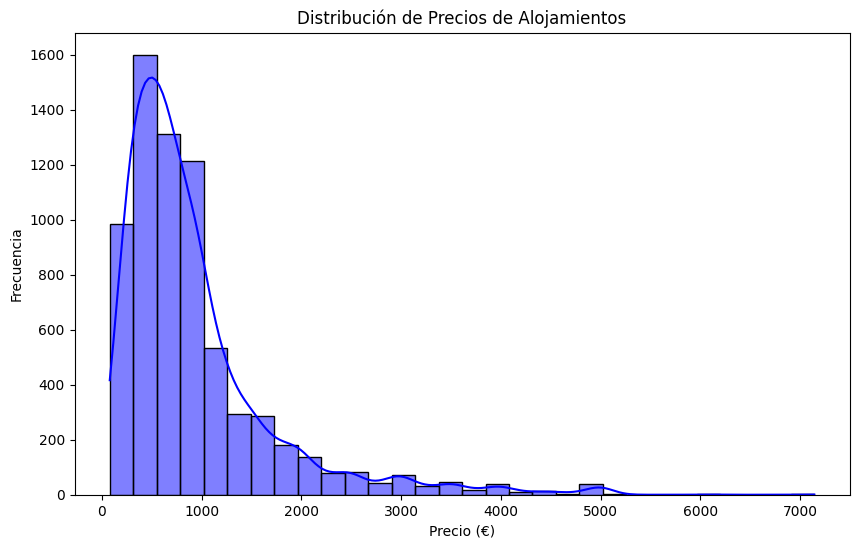

In [45]:
plt.figure(figsize=(10, 6))
sns.histplot(df_with_rating['price'], bins=30, kde=True, color='blue')
plt.title('Distribución de Precios de Alojamientos')
plt.xlabel('Precio (€)')
plt.ylabel('Frecuencia')
plt.show()

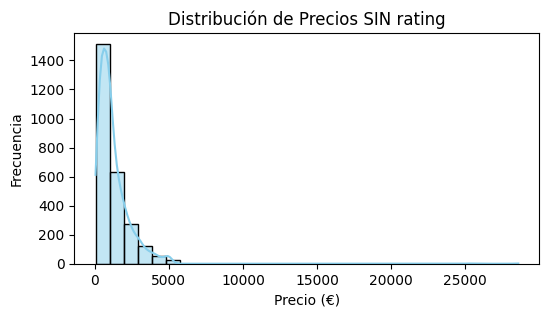

In [102]:
plt.figure(figsize=(6, 3))
sns.histplot(df_no_rating['price'], bins=30, kde=True, color='skyblue', alpha=0.5)
plt.title('Distribución de Precios SIN rating')
plt.xlabel('Precio (€)')
plt.ylabel('Frecuencia')
plt.show()

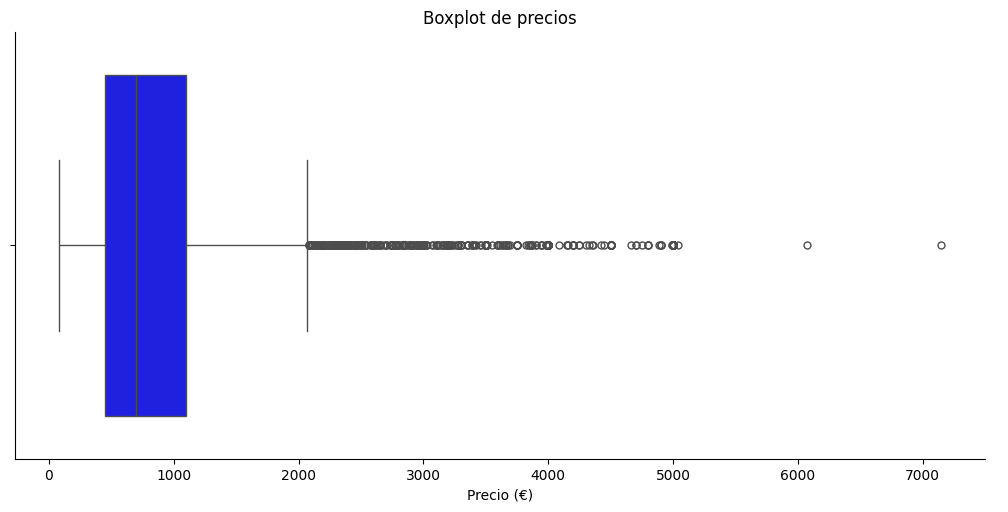

In [65]:
sns.catplot(data=df_with_rating, x='price', kind='box', color='blue',height=5, aspect=2)
plt.title('Boxplot de precios')
plt.xlabel('Precio (€)')
plt.show();

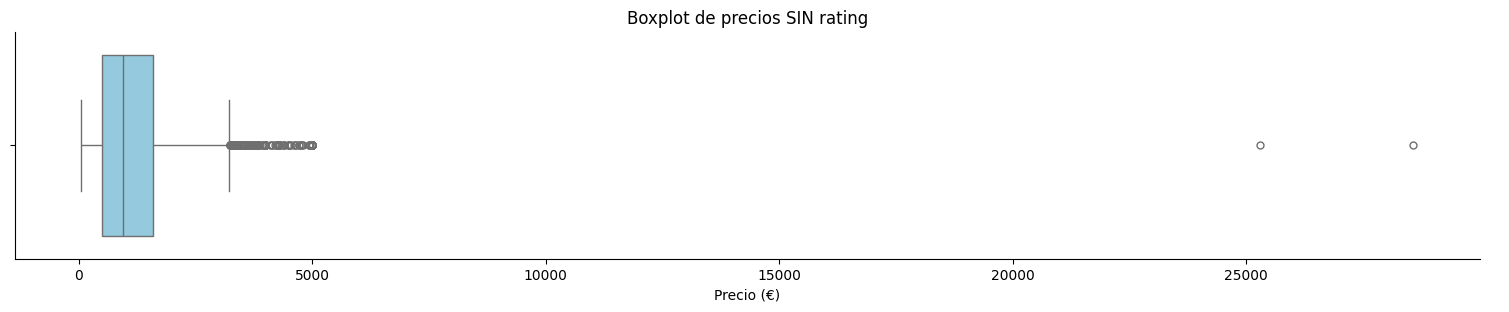

In [106]:
sns.catplot(data=df_no_rating, x='price', kind='box', color='skyblue',height=3, aspect=5)
plt.title('Boxplot de precios SIN rating')
plt.xlabel('Precio (€)')
plt.show();

La distribución del precio en los alojamientos con y sin rating es similar, la única diferencia notoria son dos outliers cuyo precio supera los 25.000€ en los alojamientos sin rating.

## Rating - distribución

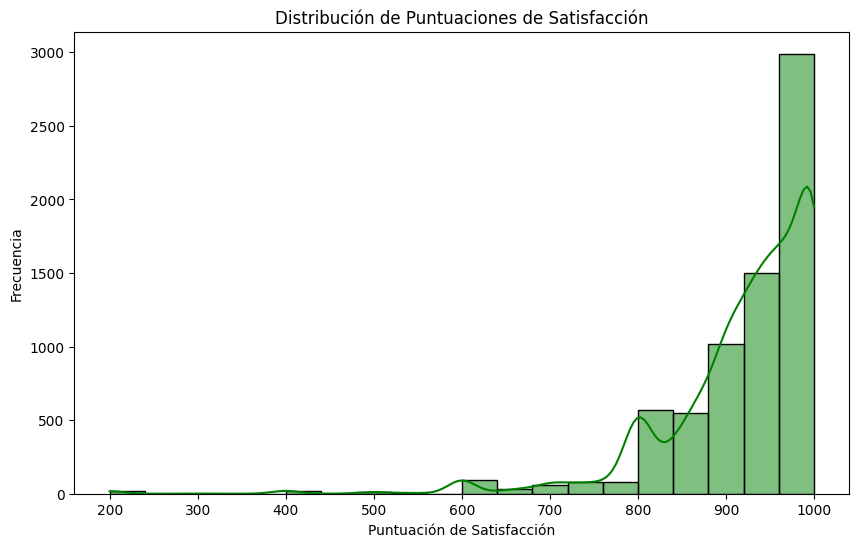

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_with_rating['review_scores_rating'], bins=20, kde=True, color='green')
plt.xlabel('Puntuación de Satisfacción')
plt.ylabel('Frecuencia')
plt.title('Distribución de Puntuaciones de Satisfacción')
plt.show()

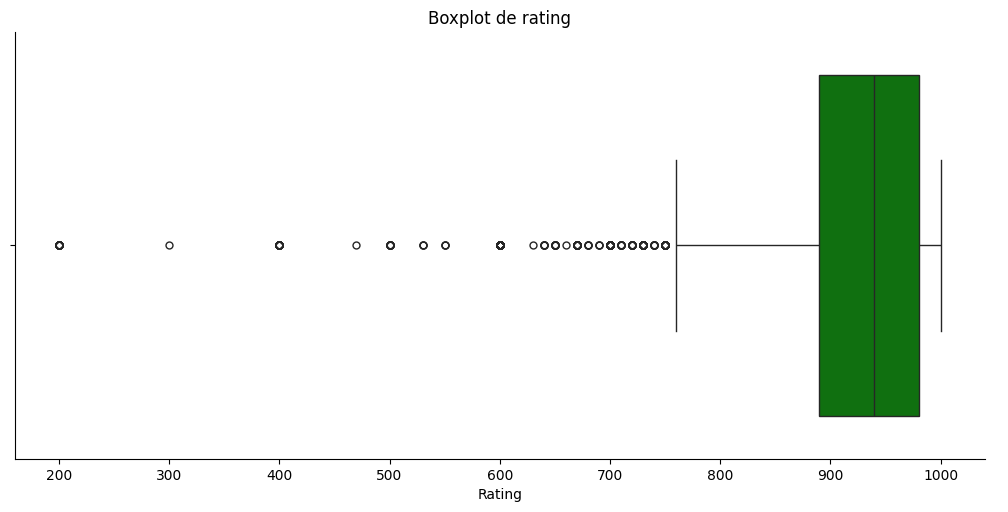

In [66]:
sns.catplot(data=df_with_rating, x='review_scores_rating', kind='box', color='green', height=5, aspect=2)
plt.title('Boxplot de rating')
plt.xlabel('Rating')
plt.show();

## Correlación

In [50]:
correlacion = df_with_rating[['price', 'review_scores_rating']].corr()
correlacion

,price,review_scores_rating
price,1.000000,0.042686
review_scores_rating,0.042686,1.000000


La matriz de correlación muestra que la correlación entre precio y puntuación de satisfacción (review_scores_rating) es 0.043, lo que indica una correlación muy débil y positiva.
Correlación baja lo que sugiere que no hay una relación lineal significativa entre el precio y la puntuación de satisfacción.
Los factores que influyen en la satisfacción pueden ser más complejos que el precio (por ejemplo, la ubicación, el servicio, la limpieza, etc.).
Puede que algunos alojamientos más caros no cumplan con las expectativas de los clientes, lo que reduce la satisfacción.
Los precios podrían no estar alineados de manera directa con la calidad percibida de los alojamientos en algunas áreas.

## Gráfico de dispersión
Se crea un gráfico de histograma bivariado para observar la relación entre las dos variables.

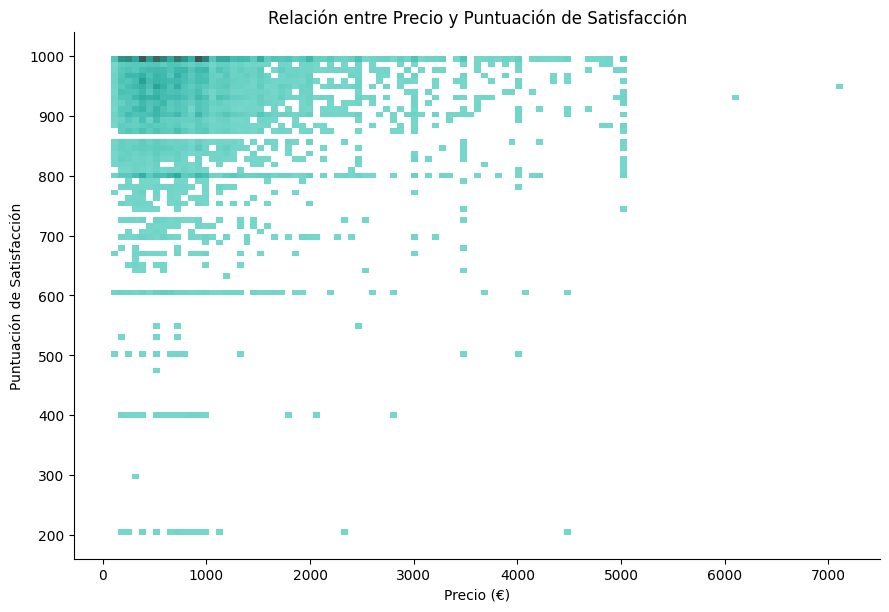

In [89]:
sns.displot(x=df_with_rating['price'], y=df_with_rating['review_scores_rating'], color="turquoise", height=6, aspect=1.5)
plt.xlabel('Precio (€)')
plt.ylabel('Puntuación de Satisfacción')
plt.title('Relación entre Precio y Puntuación de Satisfacción')
plt.show()

Los precios se concentran en los rangos más bajos y las puntuaciones se concentran en las más altas. Existen gran cantidad de alojamientos de precios menores de 1000 con puntuaciones excelentes.

## Analisis por ciudad

In [ ]:
orden_price_category=['Económico', 'Accesible', 'Medio', 'Alto', 'Premium', 'Exclusivo']
df_with_rating['price_category'] = pd.Categorical(df_with_rating['price_category'], categories=orden_price_category, ordered=True)

t_frecuencia_precio_ciudad = pd.crosstab(df_with_rating['price_category'], df_with_rating['city'])
t_frecuencia_precio_ciudad

C:\Users\Evelyn\AppData\Local\Temp\ipykernel_16044\3011575187.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_rating['price_category'] = pd.Categorical(df_with_rating['price_category'], categories=orden_price_category, ordered=True)


city,barcelona,girona,madrid,malaga,mallorca,menorca,sevilla,valencia
price_category,,,,,,,,
Económico,694,60,498,112,58,10,78,130
Accesible,433,165,352,119,90,16,114,117
Medio,337,256,412,107,166,24,100,113
Alto,345,228,245,49,291,37,81,47
Premium,267,192,133,27,351,58,48,19
Exclusivo,9,7,5,1,15,1,6,2


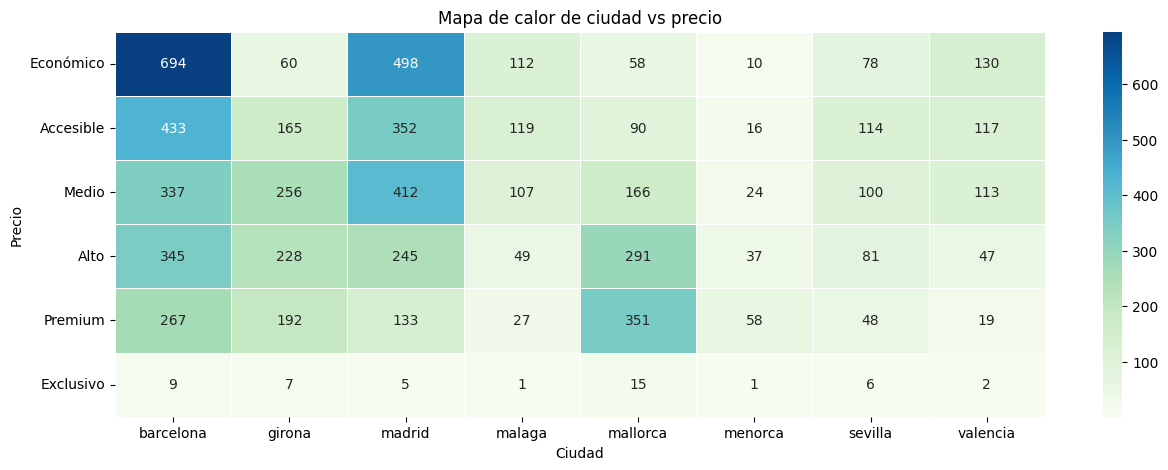

In [133]:
plt.figure(figsize=(15,5))
sns.heatmap(t_frecuencia_precio_ciudad, annot=True, fmt='d', cmap='GnBu', linewidths=0.5)

plt.title("Mapa de calor de ciudad vs precio")
plt.xlabel("Ciudad")
plt.ylabel("Precio")
plt.show()

### Correlación

In [ ]:
# Calcular la correlación entre 'price' y 'review_scores_rating' para cada ciudad
correlaciones_por_ciudad = df_with_rating.groupby('city')[['price', 'review_scores_rating']].corr().iloc[0::2, 1]

# Mostrar las correlaciones por ciudad
print("Correlación entre Precio y Satisfacción por Ciudad:")
print(correlaciones_por_ciudad)

Correlación entre Precio y Satisfacción por Ciudad:
city            
barcelona  price   -0.046467
girona     price    0.106736
madrid     price    0.055612
malaga     price    0.104960
mallorca   price    0.072220
menorca    price    0.083206
sevilla    price    0.007406
valencia   price    0.048165
Name: review_scores_rating, dtype: float64


En todas las ciudades analizadas, la correlación entre el precio del alojamiento y la satisfacción de los clientes es muy débil o prácticamente inexistente. Esto sugiere que el precio no es un factor determinante en la satisfacción de los clientes en estas localidades. Es probable que otros factores, como la calidad del servicio, la ubicación, las comodidades ofrecidas y la relación calidad-precio, tengan un impacto más significativo en la satisfacción de los huéspedes.

### Scatterplot

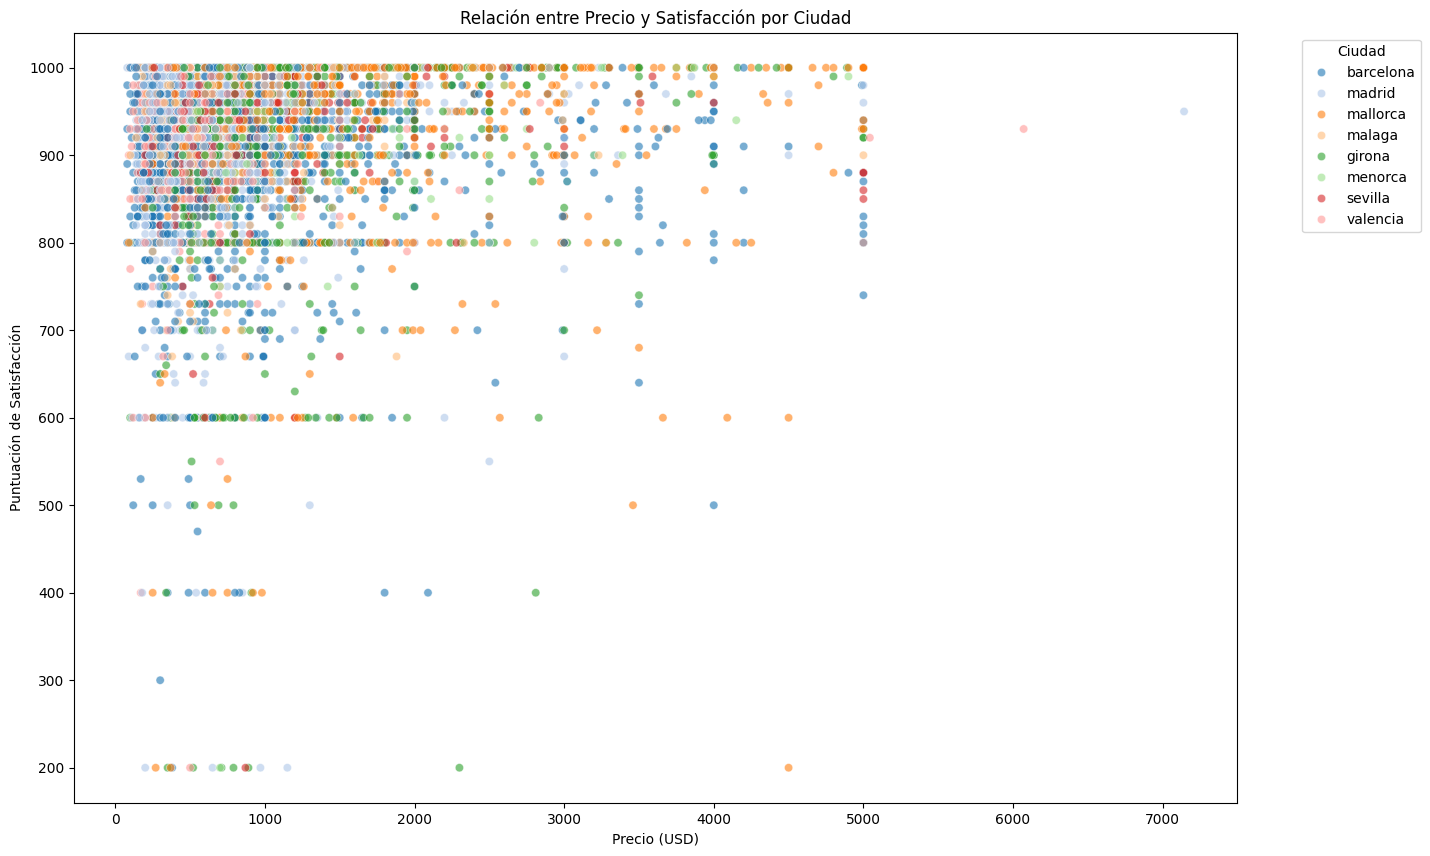

In [ ]:
# Graficar la relación entre 'precio' y 'satisfacción' por ciudad
plt.figure(figsize=(15, 10))
sns.scatterplot(x='price', y='review_scores_rating', hue='city', data=df_with_rating, palette='tab20', alpha=0.6)
plt.title('Relación entre Precio y Satisfacción por Ciudad')
plt.xlabel('Precio (€)')
plt.ylabel('Puntuación de Satisfacción')
plt.legend(title='Ciudad', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### Boxplot - Satisfacción por ciudad

C:\Users\Evelyn\AppData\Local\Temp\ipykernel_16044\4019645931.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='city', y='review_scores_rating', data=df_with_rating, palette='Set3')


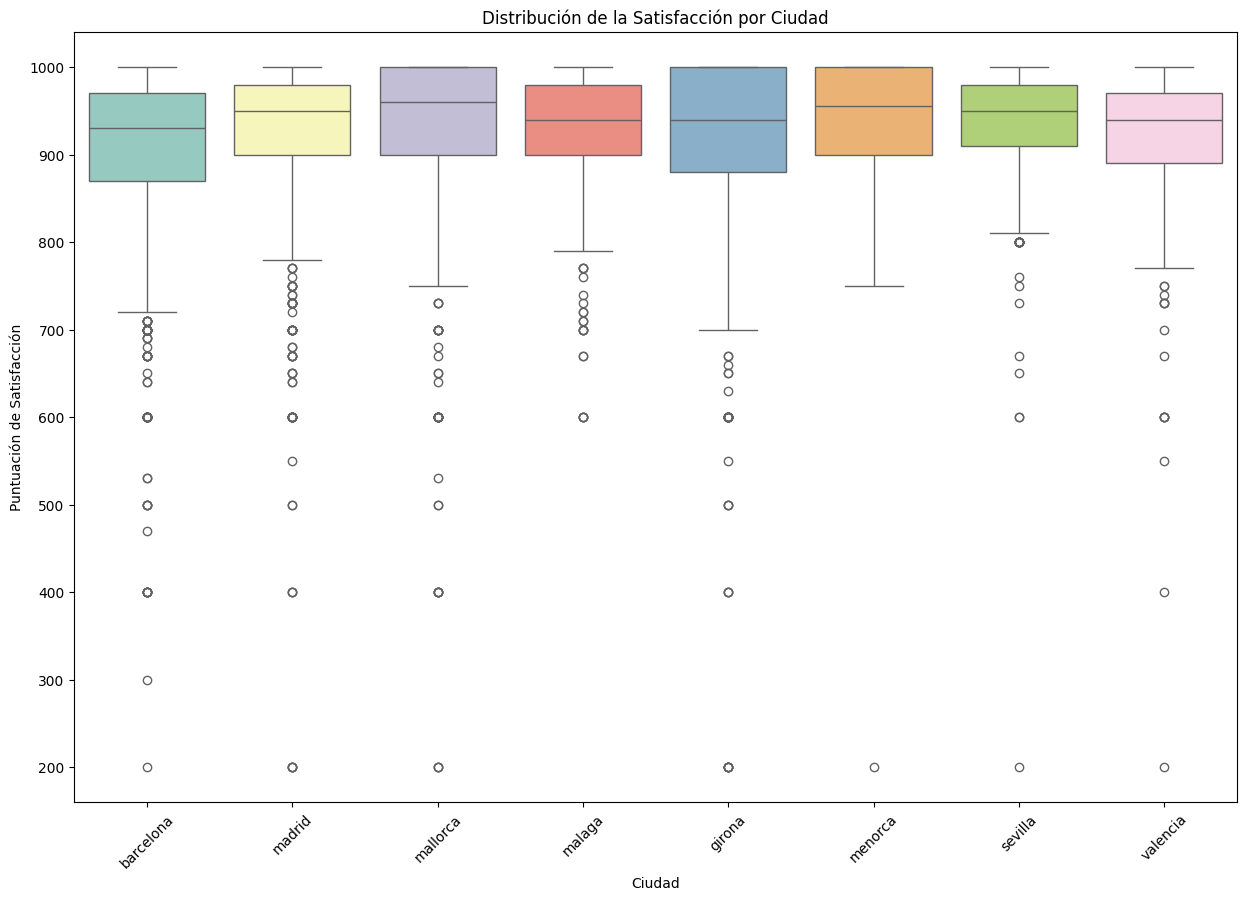

In [ ]:
plt.figure(figsize=(15, 10))
sns.boxplot(x='city', y='review_scores_rating', data=df_with_rating, palette='Set3')
plt.title('Distribución de la Satisfacción por Ciudad')
plt.xlabel('Ciudad')
plt.ylabel('Puntuación de Satisfacción')
plt.xticks(rotation=45)
plt.show()

### Precio por ciudad

C:\Users\Evelyn\AppData\Local\Temp\ipykernel_16044\272745611.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='city', y='price', data=df_with_rating, palette='Set3')


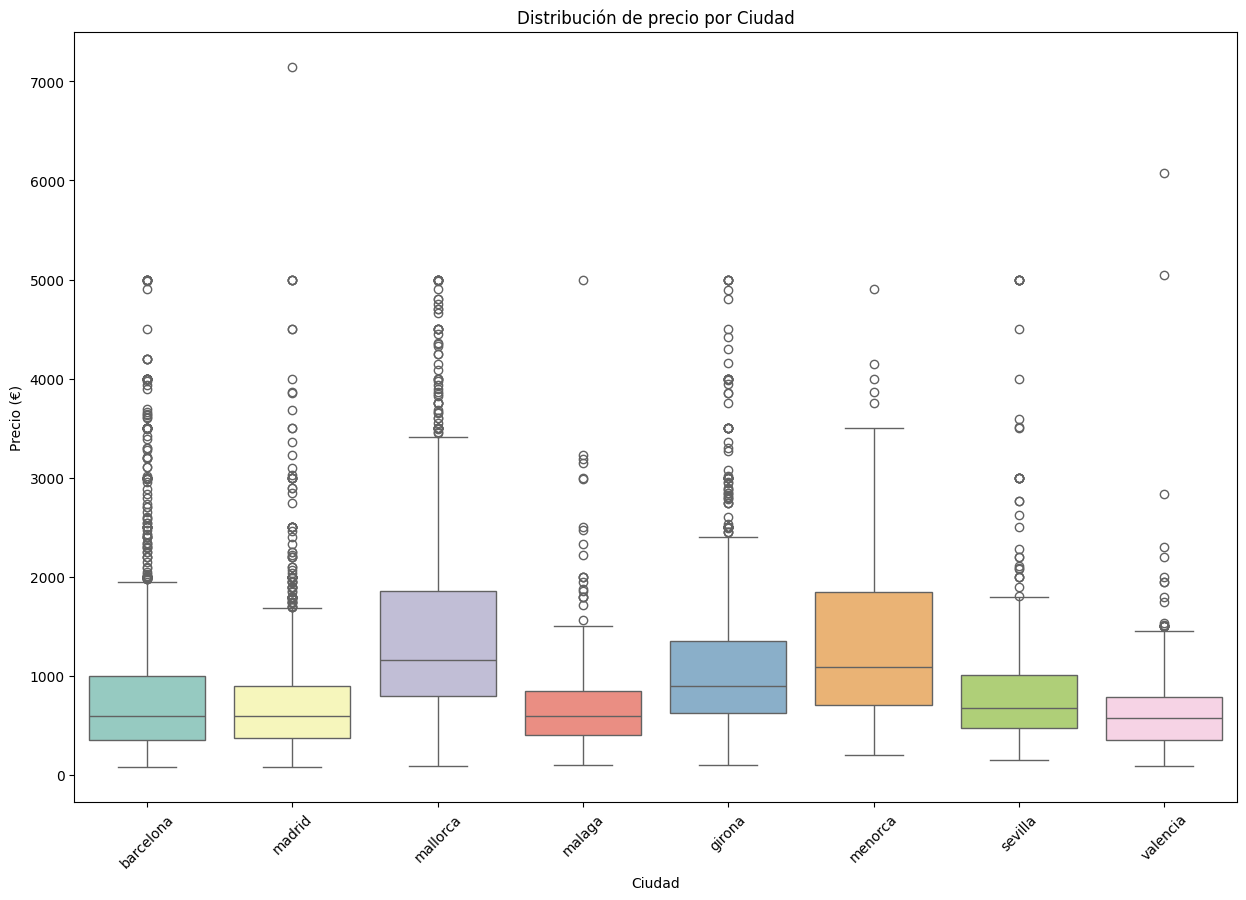

In [86]:
plt.figure(figsize=(15, 10))
sns.boxplot(x='city', y='price', data=df_with_rating, palette='Set3')
plt.title('Distribución de precio por Ciudad')
plt.xlabel('Ciudad')
plt.ylabel('Precio (€)')
plt.xticks(rotation=45)
plt.show()

### Relación precio vs rating por ciudad

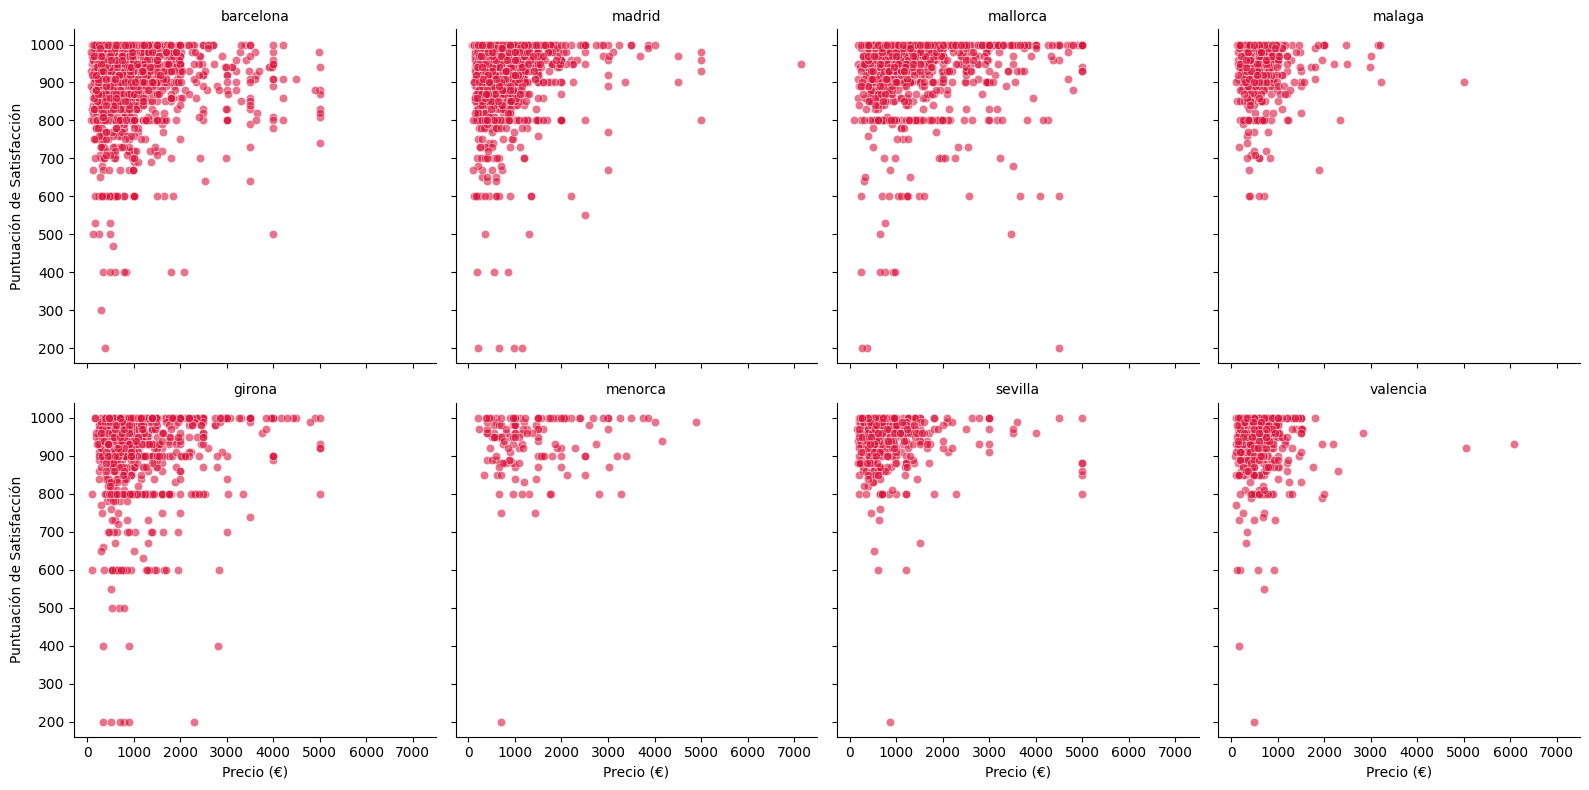

In [98]:
unique_cities = df_with_rating['city'].unique()

g = sns.FacetGrid(df_with_rating, col='city', col_wrap=4, height=4, sharex=True, sharey=True)
g.map_dataframe(sns.scatterplot, x='price', y='review_scores_rating', color='crimson', alpha=0.6)
g.set_axis_labels('Precio (€)', 'Puntuación de Satisfacción')
g.set_titles(col_template='{col_name}')
plt.show()